<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2024

#### 11220IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## A. Checking and Preprocessing

In [2]:
import pandas as pd

df = pd.read_csv('sample_data/nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


In [ ]:
plot = df.plot('Date', 'Close', figsize=(15, 5))

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
# checking for null values
df.isnull().sum()

In [5]:
df = df.dropna()

In [6]:
df.shape

(4733, 7)

In [ ]:
df.describe()

Nomalization

In [12]:
# Select the columns containing the inputs
input_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

In [13]:
# Normalize the inputs using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[input_columns] = scaler.fit_transform(df[input_columns])

# Display the normalized DataFrame
print(df)

            Date      Open      High       Low     Close    Volume  OpenInt
0     1999-01-22  0.001534  0.002262  0.000970  0.001208  0.073288        0
1     1999-01-25  0.001621  0.001751  0.001367  0.001942  0.013800        0
2     1999-01-26  0.001884  0.001921  0.001413  0.001338  0.009296        0
3     1999-01-27  0.001226  0.001280  0.001103  0.001338  0.006660        0
4     1999-01-28  0.001183  0.001109  0.001413  0.001295  0.006169        0
...          ...       ...       ...       ...       ...       ...      ...
4728  2017-11-06  0.972235  0.960019  0.976568  0.969704  0.038979        0
4729  2017-11-07  0.988054  0.973453  0.992519  0.980733  0.042744        0
4730  2017-11-08  0.994192  0.969313  0.979135  0.967516  0.052205        0
4731  2017-11-09  0.963122  0.943226  0.946482  0.949646  0.095708        0
4732  2017-11-10  1.000000  1.000000  1.000000  1.000000  0.125371        0

[4733 rows x 7 columns]


#### Converting the DataFrame to a NumPy Array

In [16]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [17]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Select features
features = df[['Open', 'High', 'Low', 'Close']]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=10,step=15)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')
print(f'')


# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (315, 10, 4)
Shape of data y: (315,)

Shape of data x_train: (227, 10, 4)
Shape of data y_train: (227,)
Shape of data x_val: (57, 10, 4)
Shape of data y_val: (57,)
Shape of data x_test: (31, 10, 4)
Shape of data y_test: (31,)
Number of samples in training and validation are 227 and 57.


## B. Defining Neural Networks

In [18]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## C. Training the Neural Network

In [19]:
# Check your GPU status.
!nvidia-smi

Wed May  1 06:55:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

#### Visualizing the model performance

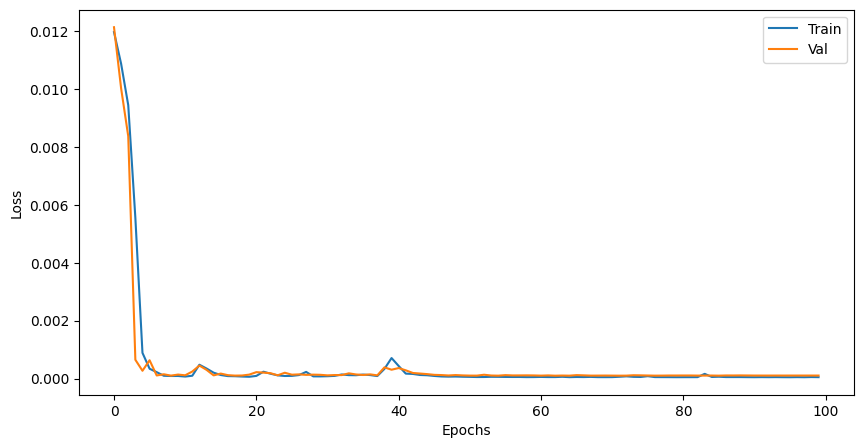

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [26]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

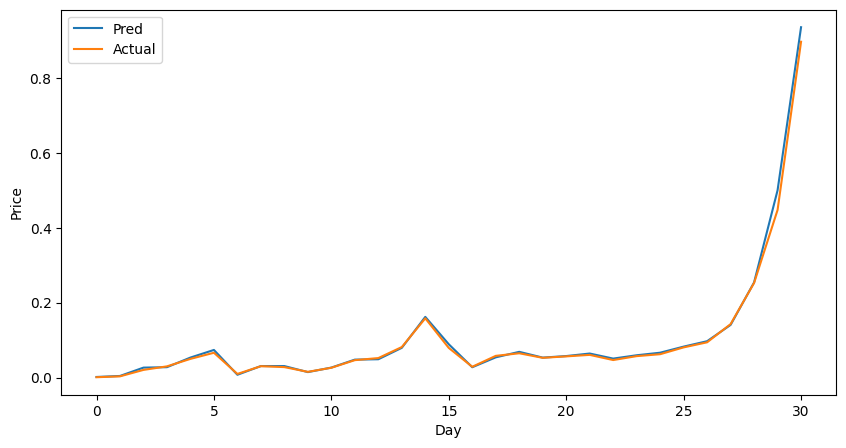

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()